# 6.4 Linear Regression Analysis

## Table of Contents
### 1. Import Libraries
### 2. Import Sales Invoice Data
#### 2.1 Merge Dataframes
#### 2.2 Merging, Cleaning, & Wrangling Location & Currency Data
### 3. Data Prep for Regression Analysis
### 4. Regression Analysis
### 5. Customer Category Regression Analysis
#### 5.1 Look at Hotel and Restaurant Only
### 6. Export Dataframes

### 1. Import Libraries

In [107]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import sklearn
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

### 2. Import Sales Invoice Data

In [109]:
# Define Path
path = r'C:\Users\daxma\OneDrive\Desktop\Data Analytics\05-25 Kevala Ceramics Analysis'

# Import Sales Invoice Detail Data
invoice_detail_file_path = os.path.join(path, '02 Data', 'Prepared Data', 'Accurate Accounts Data Cleaned', 'Sales Invoice Data', 'sales_invoice_detail_extended_cleaned.csv')
invoice_detail_ext = pd.read_csv(invoice_detail_file_path)

# check output
invoice_detail_ext.head()

,Create Date,Company_Name,NPWP Customer Sales Invoice,Product_Code#,Item Name,Quantity,@Price,Discount,Total Price,DPP Sales Invoice,Address Sales Invoice,Full Address,invoice_number
0,2023-02-09 00:00:00,Shed,NaN,ITEM-00339,Dessert Plate D.28,5.0,150000.0,0.0,750000.0,3166667.0,NaN,NaN,SI.2023.01.00019
1,2023-02-09 00:00:00,Shed,NaN,SB-0001,Serving Bowl,1.0,200000.0,0.0,200000.0,3166667.0,NaN,NaN,SI.2023.01.00019
2,2023-02-09 00:00:00,Shed,NaN,ITEM-00092,SIDE PLATE,2.0,100000.0,0.0,200000.0,3166667.0,NaN,NaN,SI.2023.01.00019
3,2023-02-09 00:00:00,Shed,NaN,ITEM-00340,Candle L,1.0,150000.0,0.0,150000.0,3166667.0,NaN,NaN,SI.2023.01.00019
4,2023-02-09 00:00:00,Shed,NaN,ITEM-00341,Candle M,1.0,100000.0,0.0,100000.0,3166667.0,NaN,NaN,SI.2023.01.00019


In [110]:
# Import Sales Invoice List Data
invoice_list_file_path = os.path.join(path, '02 Data', 'Prepared Data', 'Accurate Accounts Data Cleaned', 'Sales Invoice Data', 'sales_invoice_list_extended_cleaned.csv')
invoice_list_ext = pd.read_csv(invoice_list_file_path, encoding='latin1')

# Check output
invoice_list_ext.head()

,invoice_number,Date,Company_Name,Brand_Name,Total,Customer_Category,Trade_Type
0,000030-024170-20240508-000447,08 May 2024,Marina Bay Sands,MBS,"7,740.",Hotel,Export
1,00003093043220250310000023,10 Mar 2025,"CPRC (Maldives) Pvt, Ltd (Ritz Carlton Maldives)",Ritz Carlton Maldives,"2,150.",Hotel,Export
2,004817#08010000025220250201000912,01 Feb 2025,AL GHALIA W.L.L,Jihad,"1,016.6",Agent,Export
3,005/KEVALA/OUT/III/2024,01 Jun 2024,Six Senses Amaala,Amaala,0.,Hotel,Export
4,006830#00003002238320250212043298,13 Feb 2025,Renarte General Trading LLC,Renarte,984.,Agent,Export


#### 2.1 Merge Dataframes

In [112]:
# Aggregate quantity of items in invoice_detail and create subset with columns we want to merge
invoice_summary_ext = invoice_detail_ext.groupby('invoice_number').agg(
    Total_Quantity=('Quantity', 'sum')
).reset_index()

# Check output
invoice_summary_ext.head()

,invoice_number,Total_Quantity
0,000030-024170-20240508-000447,516.0
1,00003093043220250310000023,225.0
2,004817#08010000025220250201000912,60.0
3,005/KEVALA/OUT/III/2024,50.0
4,006830#00003002238320250212043298,48.0


In [113]:
# Merge dataframes
invoice_enriched_ext = pd.merge(
    invoice_list_ext,
    invoice_summary_ext,
    how='left',
    on='invoice_number'
)

# check output
invoice_enriched_ext.head()

,invoice_number,Date,Company_Name,Brand_Name,Total,Customer_Category,Trade_Type,Total_Quantity
0,000030-024170-20240508-000447,08 May 2024,Marina Bay Sands,MBS,"7,740.",Hotel,Export,516.0
1,00003093043220250310000023,10 Mar 2025,"CPRC (Maldives) Pvt, Ltd (Ritz Carlton Maldives)",Ritz Carlton Maldives,"2,150.",Hotel,Export,225.0
2,004817#08010000025220250201000912,01 Feb 2025,AL GHALIA W.L.L,Jihad,"1,016.6",Agent,Export,60.0
3,005/KEVALA/OUT/III/2024,01 Jun 2024,Six Senses Amaala,Amaala,0.,Hotel,Export,50.0
4,006830#00003002238320250212043298,13 Feb 2025,Renarte General Trading LLC,Renarte,984.,Agent,Export,48.0


In [114]:
# Check data types
invoice_enriched_ext.dtypes

invoice_number        object
Date                  object
Company_Name          object
Brand_Name            object
Total                 object
Customer_Category     object
Trade_Type            object
Total_Quantity       float64
dtype: object

In [115]:
# Check shape
invoice_enriched_ext.shape

(4477, 8)

In [116]:
# Convert 'Total' column to numeric
# Clean common formatting issues — remove non-numeric symbols
invoice_enriched_ext['Total'] = (
    invoice_enriched_ext['Total']
    .astype(str)
    .str.replace(r'[^\d.,]', '', regex=True)  # keep only digits, commas, and dots
    .str.replace(',', '', regex=False)        # remove thousand separators
    .str.strip()
)

# Convert cleaned string to float
invoice_enriched_ext['Total'] = pd.to_numeric(invoice_enriched_ext['Total'], errors='coerce')


In [117]:
# Check data type and sample values
print(invoice_enriched_ext['Total'].dtype)
invoice_enriched_ext['Total'].head()

float64


0    7740.0
1    2150.0
2    1016.6
3       0.0
4     984.0
Name: Total, dtype: float64

In [130]:
# Force parsing with known date format: 'DD Mon YYYY'
invoice_enriched_ext['Parsed_Date'] = pd.to_datetime(
    invoice_enriched_ext['Date'],
    format='%d %b %Y',
    errors='coerce'
)

print(invoice_enriched_ext['Parsed_Date'].isna().sum())


1


In [134]:
# Drop parsed date column
invoice_enriched_ext['Date'] = invoice_enriched_ext['Parsed_Date']
invoice_enriched_ext.drop(columns='Parsed_Date', inplace=True)

In [136]:
# Check how many values are missing in key columns
invoice_enriched_ext[['invoice_number', 'Date', 'Company_Name', 'Total', 'Total_Quantity']].isnull().sum()

invoice_number     1
Date               1
Company_Name       1
Total              1
Total_Quantity    24
dtype: int64

In [140]:
# Check how many rows have 'Total' exactly equal to 0
(invoice_enriched_ext['Total'] == 0).sum()

5

In [144]:
# Show rows where Total is exactly 0
invoice_enriched_ext[invoice_enriched_ext['Total'] == 0]

,invoice_number,Date,Company_Name,Brand_Name,Total,Customer_Category,Trade_Type,Total_Quantity
3,005/KEVALA/OUT/III/2024,2024-06-01,Six Senses Amaala,Amaala,0.0,Hotel,Export,50.0
2113,SI.2023.06.00345,2023-06-30,Jia,Jia,0.0,Artist Collaboration,Local,1.0
4395,SI.2024.09.00001,2024-09-04,Omer Faruk Yunus,Six Senses Turkey,0.0,Hotel,Export,1.0
4435,SI.2024.11.00011,2024-11-14,Six Senses Amaala,Amaala,0.0,Hotel,Export,1.0
4474,SRT.2024.11.00003,2024-11-12,Zil Pasyon Resorts LTD,Zil Pasyon,0.0,Hotel,Export,NaN


In [146]:
# Manually update known totals values
invoice_enriched_ext.loc[invoice_enriched_ext['invoice_number'] == '005/KEVALA/OUT/III/2024', 'Total'] = 596.5
invoice_enriched_ext.loc[invoice_enriched_ext['invoice_number'] == 'SI.2024.09.00001', 'Total'] = 941.46

In [150]:
# Drop any remaining rows with Total == 0
invoice_enriched_ext = invoice_enriched_ext[invoice_enriched_ext['Total'] != 0]

In [152]:
# Check how many rows have 'Total' exactly equal to 0
(invoice_enriched_ext['Total'] == 0).sum()

0

In [163]:
# Drop rows where all values are missing
invoice_enriched_ext.dropna(how='all', inplace=True)

In [165]:
# Check how many values are missing in key columns
invoice_enriched_ext[['invoice_number', 'Date', 'Company_Name', 'Total', 'Total_Quantity']].isnull().sum()

invoice_number     0
Date               0
Company_Name       0
Total              0
Total_Quantity    22
dtype: int64

- The rows showing total_quantity missing still have valid data in other columns so they will be kept for now.

#### 2.2 Merging, Cleaning, & Wrangling Location & Currency Data

In [169]:
# Import Sales Invoice Enriched data previously created
invoice_enriched_file_path = os.path.join(path, '02 Data', 'Prepared Data', '6.3', 'invoice_enriched.csv')
invoice_enriched = pd.read_csv(invoice_enriched_file_path)

# check output
invoice_enriched.head()

,invoice_number,Date,Company_Name,Brand_Name,Total,Customer_Category,Trade_Type,Total_Quantity,Full_Address,Country,Total_Invoice_USD
0,000030-024170-20240508-000447,2024-05-08,marina bay sands,MBS,7740.0,Hotel,Export,516.0,NaN,Singapore,7740.0
1,3.09304E+21,2025-03-10,"cprc (maldives) pvt, ltd (ritz carlton maldives)",Ritz Carlton Maldives,2150.0,Hotel,Export,NaN,NaN,Maldives,2150.0
2,004817#08010000025220250201000912,2025-02-01,al ghalia w.l.l,Jihad,1016.6,Agent,Export,60.0,"Villa 927, Road 3830,Block 338, AdilyaKingdom ...",Bahrain,1016.6
3,005/KEVALA/OUT/III/2024,2024-06-01,six senses amaala,Amaala,596.5,Hotel,Export,50.0,NaN,Saudi Arabia,596.5
4,006830#00003002238320250212043298,2025-02-13,renarte general trading llc,Renarte,984.0,Agent,Export,48.0,"Office # 804, grosveenor Business Tower, PO Bo...",United Arab Emirates,984.0


In [171]:
# Merge location data using invoice number
invoice_enriched_ext = pd.merge(
    invoice_enriched_ext,
    invoice_enriched[['invoice_number', 'Country']],  # or 'country_cleaned' if applicable
    on='invoice_number',
    how='left'
)


In [175]:
# Check missing country values
missing = invoice_enriched_ext['Country'].isna().sum()
print(f"{missing} rows are still missing country info.")


3008 rows are still missing country info.


In [181]:
# Fill all rows where 'trade_type' is 'local' with 'Indonesia'
invoice_enriched_ext.loc[invoice_enriched_ext['Trade_Type'] == 'Local', 'Country'] = 'Indonesia'

In [183]:
# Check missing country values
missing = invoice_enriched_ext['Country'].isna().sum()
print(f"{missing} rows are still missing country info.")


142 rows are still missing country info.


In [185]:
# Create a mapping from Company_Name to Country using rows where Country is not missing
company_country_map = (
    invoice_enriched_ext
    .dropna(subset=['Country'])
    .drop_duplicates(subset=['Company_Name'])[['Company_Name', 'Country']]
    .set_index('Company_Name')['Country']
)

# Fill missing Country values by mapping from Company_Name
invoice_enriched_ext['Country'] = invoice_enriched_ext.apply(
    lambda row: company_country_map[row['Company_Name']]
    if pd.isna(row['Country']) and row['Company_Name'] in company_country_map
    else row['Country'],
    axis=1
)


In [187]:
# Check missing country values
missing = invoice_enriched_ext['Country'].isna().sum()
print(f"{missing} rows are still missing country info.")


63 rows are still missing country info.


In [191]:
# Import customer list to fill in missing countries
customer_list_file_path = os.path.join(path, '02 Data', 'Prepared Data', 'Accurate Accounts Data Cleaned', 'Customer List', 'Customer_List_Kevala.csv')
customer_list = pd.read_csv(customer_list_file_path, encoding='latin1')

# Check output
customer_list.head()

,Company_Name,Brand_Name,Customer_Category,Trade_Type,Country,City
0,Reem Kuwatly,Reem Kuwatly,Agent,Local,Indonesia,NaN
1,Cempaka Interior,Cempaka Interior,Agent,Local,Indonesia,Bali
2,GLANCY FAWCET,C.00626,Agent,Export,NaN,NaN
3,Hospitality Enterprise Resources Corporation,Filinvest,Agent,Export,Philippines,NaN
4,Garden Barn Inc,Garden Barn 1,Agent,Export,Philippines,NaN


In [193]:
# Standardize formatting
customer_list['Company_Name'] = customer_list['Company_Name'].str.lower().str.strip()

# Standardize company name formatting in all datasets
for df in [invoice_enriched_ext]:
    df['Company_Name'] = df['Company_Name'].str.lower().str.strip()

In [195]:
# Clean column names to remove any hidden spaces
customer_list.columns = customer_list.columns.str.strip()

In [197]:
# Check for duplicates in Company_Name
customer_list['Company_Name'].value_counts().loc[lambda x: x > 1]

Company_Name
sutera bali                  4
kilo kitchen perenan         3
shelter indonesia group      3
good food cafe               3
brett hospitality group      3
usaha liburan uluwatu        2
pasar tani indoguna, cv      2
groupx kolektif indonesia    2
bali selaras indah sejati    2
barba rossa fraters          2
dapur asian lokal            2
puri zuqni                   2
fieldcrest enterprise        2
Name: count, dtype: int64

In [199]:
# Keep the first country entry per company
customer_country_map = customer_list[['Company_Name', 'Country']].drop_duplicates(subset='Company_Name')

In [201]:
# Check invoices shape
invoice_enriched_ext.shape

(4473, 9)

In [203]:
# Create a dictionary mapping from Company_Name to Country
company_to_country = customer_country_map.set_index('Company_Name')['Country'].to_dict()

# Fill missing countries in invoice_enriched_ext using the mapping
invoice_enriched_ext['Country'] = invoice_enriched_ext.apply(
    lambda row: company_to_country.get(row['Company_Name'], row['Country']) 
    if pd.isna(row['Country']) else row['Country'],
    axis=1
)


In [207]:
# Check missing
invoice_enriched_ext['Country'].isna().sum()

15

In [211]:
# Check missing rows
invoice_enriched_ext[invoice_enriched_ext['Country'].isna()]

,invoice_number,Date,Company_Name,Brand_Name,Total,Customer_Category,Trade_Type,Total_Quantity,Country
122,INV-00004/KEVALA/OUT/05/2025,2025-05-05,alterize,Alterize,2800000.00,Umum,Umum,700.0,NaN
167,INV-00027/KEVALA/OUT/04/2025,2025-04-16,alterize,Alterize,700000.00,Umum,Umum,175.0,NaN
210,INV-00042/KEVALA/OUT/03/2025,2025-03-20,alterize,Alterize,200000.00,Umum,Umum,50.0,NaN
1095,SI.2023.02.00050,2023-02-27,mondrian hotel,Mondrian Hotel,765.00,Hotel,Export,50.0,NaN
1096,SI.2023.02.00051,2023-02-27,steve lancaster,Steve Lancaster,364.00,Restaurant,Export,28.0,NaN
1153,SI.2023.02.00120,2023-04-01,polse,Polse,70.00,Restaurant,Export,1.0,NaN
1246,SI.2023.02.00324,2023-02-28,umum,umum,50000.00,Umum,Umum,1.0,NaN
1853,SI.2023.05.00278,2023-05-01,mohit vasandi,Mohit Vasandi,60642728.92,Personal,Export,322.0,NaN
1854,SI.2023.05.00281,2023-05-25,little farm,Little Farm,336.00,Restaurant,Export,24.0,NaN
3132,SI.2023.10.00237,2023-10-11,celavi,Celavi,600.00,Restaurant,Export,50.0,NaN


In [217]:
# Manually apply countries
invoice_enriched_ext.loc[invoice_enriched_ext['Company_Name'] == 'alterize', 'Country'] = 'Indonesia'
invoice_enriched_ext.loc[invoice_enriched_ext['Company_Name'] == 'mondrian hotel', 'Country'] = 'Singapore'
invoice_enriched_ext.loc[invoice_enriched_ext['Company_Name'] == 'steve lancaster', 'Country'] = 'Singapore'
invoice_enriched_ext.loc[invoice_enriched_ext['Company_Name'] == 'polse', 'Country'] = 'Singapore'
invoice_enriched_ext.loc[invoice_enriched_ext['Company_Name'] == 'celavi', 'Country'] = 'Singapore'
invoice_enriched_ext.loc[invoice_enriched_ext['Company_Name'] == 'koa', 'Country'] = 'Australia'

In [219]:
# Check missing rows
invoice_enriched_ext[invoice_enriched_ext['Country'].isna()]

,invoice_number,Date,Company_Name,Brand_Name,Total,Customer_Category,Trade_Type,Total_Quantity,Country
1246,SI.2023.02.00324,2023-02-28,umum,umum,50000.00,Umum,Umum,1.0,NaN
1853,SI.2023.05.00278,2023-05-01,mohit vasandi,Mohit Vasandi,60642728.92,Personal,Export,322.0,NaN
1854,SI.2023.05.00281,2023-05-25,little farm,Little Farm,336.00,Restaurant,Export,24.0,NaN
3463,SI.2023.11.00307,2023-11-21,ocean product,Ocean Product,16284.40,Restaurant,Export,930.0,NaN
3754,SI.2023.12.00379,2023-12-13,ramos,RAMOS,871.04,Umum,Export,57.0,NaN


- A location was not able to be found for these invoices so they will be left

In [224]:
# Show all rows where company name is 'umum'
invoice_enriched_ext[invoice_enriched_ext['Company_Name'] == 'umum']

,invoice_number,Date,Company_Name,Brand_Name,Total,Customer_Category,Trade_Type,Total_Quantity,Country
1246,SI.2023.02.00324,2023-02-28,umum,umum,50000.0,Umum,Umum,1.0,NaN


In [226]:
# Remove row with company name 'umum'
invoice_enriched_ext = invoice_enriched_ext[invoice_enriched_ext['Company_Name'] != 'umum']

In [236]:
# Currency conversion
IDR_TO_USD = 16210.298
AUD_TO_USD = 1 / 1.5198911
EUR_TO_USD = 1 / 0.84741099

In [238]:
# Covert IDR to USD and exclude rows for KOA and the two specific invoice numbers
exclude_mask = (
    (invoice_enriched_ext['Company_Name'] == 'koa') |
    (invoice_enriched_ext['invoice_number'].isin(['INV-2146/KEVALA/OUT/XII/2024', 'SI.2023.04.00256']))
)

idr_mask = (invoice_enriched_ext['Country'] == 'Indonesia') & (~exclude_mask)

invoice_enriched_ext.loc[idr_mask, 'Total_USD'] = invoice_enriched_ext.loc[idr_mask, 'Total'] / IDR_TO_USD


C:\Users\daxma\AppData\Local\Temp\ipykernel_23092\1474757143.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  invoice_enriched_ext.loc[idr_mask, 'Total_USD'] = invoice_enriched_ext.loc[idr_mask, 'Total'] / IDR_TO_USD


In [240]:
# Convert AUD to USD
aud_mask = (
    (invoice_enriched_ext['Company_Name'] == 'koa') |
    (invoice_enriched_ext['invoice_number'].isin(['INV-2146/KEVALA/OUT/XII/2024', 'SI.2023.04.00256']))
)

invoice_enriched_ext.loc[aud_mask, 'Total_USD'] = invoice_enriched_ext.loc[aud_mask, 'Total'] * AUD_TO_USD


In [242]:
# Convert SAS Marseille Office Design from EUR to USD and Update Metadata
sas_mask = invoice_enriched_ext['Company_Name'] == 'sas marseille office design'

invoice_enriched_ext.loc[sas_mask, 'Total_USD'] = invoice_enriched_ext.loc[sas_mask, 'Total'] * EUR_TO_USD
invoice_enriched_ext.loc[sas_mask, 'Country'] = 'France'
invoice_enriched_ext.loc[sas_mask, 'Trade Type'] = 'Export'

C:\Users\daxma\AppData\Local\Temp\ipykernel_23092\464398462.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  invoice_enriched_ext.loc[sas_mask, 'Trade Type'] = 'Export'


In [244]:
# Convert IDR to USD
mohit_mask = invoice_enriched_ext['Company_Name'] == 'mohit vasandi'

invoice_enriched_ext.loc[mohit_mask, 'Total_USD'] = invoice_enriched_ext.loc[mohit_mask, 'Total'] / IDR_TO_USD


In [246]:
# Check missing rows
invoice_enriched_ext['Total_USD'].isna().sum()

238

In [248]:
# Fill Missing Total_USD with Original Total (Already in USD)
invoice_enriched_ext['Total_USD'] = invoice_enriched_ext['Total_USD'].fillna(invoice_enriched_ext['Total'])

C:\Users\daxma\AppData\Local\Temp\ipykernel_23092\4008439851.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  invoice_enriched_ext['Total_USD'] = invoice_enriched_ext['Total_USD'].fillna(invoice_enriched_ext['Total'])


In [250]:
# Check missing rows
invoice_enriched_ext['Total_USD'].isna().sum()

0

In [267]:
# Remove Trade Type column mistake
if 'Trade Type' in invoice_enriched_ext.columns:
    invoice_enriched_ext.drop(columns='Trade Type', inplace=True)


C:\Users\daxma\AppData\Local\Temp\ipykernel_23092\656415136.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  invoice_enriched_ext.drop(columns='Trade Type', inplace=True)


In [269]:
# Update Trade_Type to export
invoice_enriched_ext.loc[
    invoice_enriched_ext['Company_Name'] == 'sas marseille office design',
    'Trade_Type'
] = 'Export'


In [273]:
# Check output
eur_check = invoice_enriched_ext[invoice_enriched_ext['Company_Name'] == 'sas marseille office design']
print(eur_check)


        invoice_number       Date                 Company_Name  \
4434  SI.2024.11.00019 2024-11-20  sas marseille office design   

                       Brand_Name   Total Customer_Category Trade_Type  \
4434  SAS Marseille Office Design  306.33             Hotel     Export   

      Total_Quantity Country   Total_USD  
4434             1.0  France  361.489293  


In [275]:
# Check dataframe
invoice_enriched_ext.head()

,invoice_number,Date,Company_Name,Brand_Name,Total,Customer_Category,Trade_Type,Total_Quantity,Country,Total_USD
0,000030-024170-20240508-000447,2024-05-08,marina bay sands,MBS,7740.0,Hotel,Export,516.0,Singapore,7740.0
1,00003093043220250310000023,2025-03-10,"cprc (maldives) pvt, ltd (ritz carlton maldives)",Ritz Carlton Maldives,2150.0,Hotel,Export,225.0,Maldives,2150.0
2,004817#08010000025220250201000912,2025-02-01,al ghalia w.l.l,Jihad,1016.6,Agent,Export,60.0,Bahrain,1016.6
3,005/KEVALA/OUT/III/2024,2024-06-01,six senses amaala,Amaala,596.5,Hotel,Export,50.0,Saudi Arabia,596.5
4,006830#00003002238320250212043298,2025-02-13,renarte general trading llc,Renarte,984.0,Agent,Export,48.0,United Arab Emirates,984.0


In [277]:
# Check shape
invoice_enriched_ext.shape

(4472, 10)

### 3. Data Prep for Regression Analysis

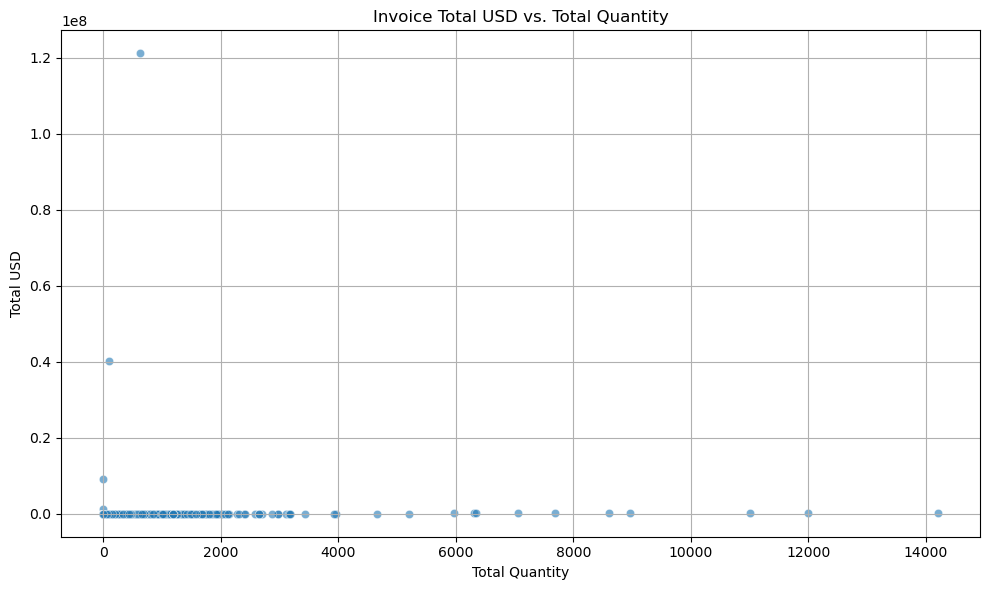

In [284]:
# Create a scatterplot using matplotlib for another look at how the chosen variables plot against each other.
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=invoice_enriched_ext,
    x='Total_Quantity',
    y='Total_USD',
    alpha=0.6
)
plt.title('Invoice Total USD vs. Total Quantity')
plt.xlabel('Total Quantity')
plt.ylabel('Total USD')
plt.grid(True)
plt.tight_layout()
plt.show()

In [286]:
invoice_enriched_ext.sort_values(by='Total_USD', ascending=False).head(10)


,invoice_number,Date,Company_Name,Brand_Name,Total,Customer_Category,Trade_Type,Total_Quantity,Country,Total_USD
390,INV-1582/KEVALA/OUT/I/2024,2024-01-03,kilo kitchen perenan,Kilo Saudi,1.212120e+08,Restaurant,Export,620.0,Saudi Arabia,1.212120e+08
2411,SI.2023.07.00368,2023-09-14,koi dessert bar melbourne,Koi Dessert,4.020840e+07,Restaurant,Export,108.0,Australia,4.020840e+07
1820,SI.2023.05.00244,2023-05-04,fieldcrest enterprise,Raffless Singapore,9.145588e+06,Agent,Export,1.0,Singapore,9.145588e+06
169,INV-00028/KEVALA/OUT/02/2025,2025-02-17,four season resort maldives,Four Season Maldives,1.214475e+06,Hotel,Export,1.0,Maldives,1.214475e+06
68,779654#00003031712320241015000163,2024-10-17,reef hospitality solutions and trading company,Sindalah,1.958808e+05,Hotel,Export,12000.0,Saudi Arabia,1.958808e+05
2415,SI.2023.07.00389,2023-07-31,the red sea real estate company 1,The Red Sea,1.666262e+05,Hotel,Export,14210.0,Saudi Arabia,1.666262e+05
52,651821#00003031712320241219000195,2024-12-21,reef hospitality solutions and trading company,Sindalah,1.260122e+05,Hotel,Export,7695.0,Saudi Arabia,1.260122e+05
21,041452#00003002206820250306441117,2025-03-06,gfh ventures company wll,Raffles Bahrain/Al Areen Palace & Spa by Accor,1.027224e+05,Hotel,Export,8970.0,Bahrain,1.027224e+05
3462,SI.2023.11.00301,2023-11-27,bawe retreat limited,Sansibar,9.992800e+04,Restaurant,Export,6342.0,Tanzania,9.992800e+04
541,INV-1761/KEVALA/OUT/III/2024,2024-03-05,hotel indonesia sanur international,Meru,1.599693e+09,Hotel,Local,11000.0,Indonesia,9.868375e+04


In [288]:
# Fix outliers by converting IDR to USD
invoices_to_convert = [
    'INV-1582/KEVALA/OUT/I/2024',      # kilo kitchen perenan
    'SI.2023.07.00368',                # koi dessert bar melbourne
    'SI.2023.05.00244',                # fieldcrest enterprise
    'INV-00028/KEVALA/OUT/02/2025'     # four season resort maldives
]

invoice_enriched_ext.loc[
    invoice_enriched_ext['invoice_number'].isin(invoices_to_convert),
    'Total_USD'
] = invoice_enriched_ext.loc[
    invoice_enriched_ext['invoice_number'].isin(invoices_to_convert),
    'Total'
] / IDR_TO_USD


In [290]:
# View the updated rows to confirm conversion
invoice_enriched_ext[
    invoice_enriched_ext['invoice_number'].isin([
        'INV-1582/KEVALA/OUT/I/2024',
        'SI.2023.07.00368',
        'SI.2023.05.00244',
        'INV-00028/KEVALA/OUT/02/2025'
    ])
][['invoice_number', 'Company_Name', 'Total', 'Total_USD']]


,invoice_number,Company_Name,Total,Total_USD
169,INV-00028/KEVALA/OUT/02/2025,four season resort maldives,1214475.0,74.919968
390,INV-1582/KEVALA/OUT/I/2024,kilo kitchen perenan,121212000.0,7477.468952
1820,SI.2023.05.00244,fieldcrest enterprise,9145588.0,564.183829
2411,SI.2023.07.00368,koi dessert bar melbourne,40208400.0,2480.423247


In [353]:
# Define save path for visualisations
save_path = r'C:\Users\daxma\OneDrive\Desktop\Data Analytics\05-25 Kevala Ceramics Analysis\04 Analysis\Visualisations'


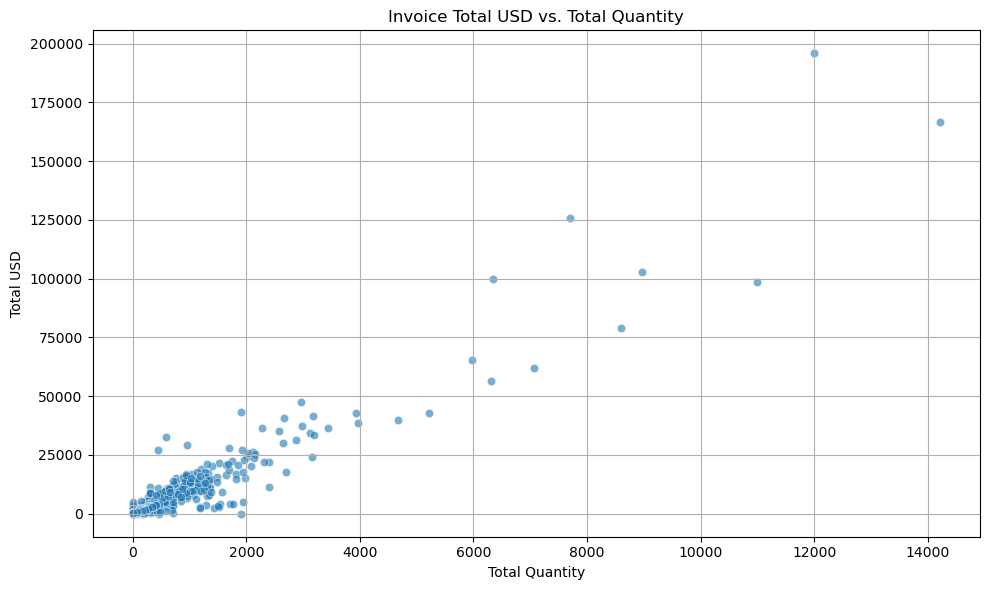

In [355]:
# Create a scatterplot using matplotlib for another look at how the chosen variables plot against each other.
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=invoice_enriched_ext,
    x='Total_Quantity',
    y='Total_USD',
    alpha=0.6
)
plt.title('Invoice Total USD vs. Total Quantity')
plt.xlabel('Total Quantity')
plt.ylabel('Total USD')
plt.grid(True)
plt.tight_layout()

# Save file
plt.savefig(os.path.join(save_path, 'quantity_vs_usd_scatterplot.png'), dpi=300)

plt.show()

#### Hypothesis
Business Hypothesis:
We hypothesize that invoices with higher total quantities will also have higher total USD values. This would suggest a positive relationship between the size of the order and the total invoice value, which is expected in a wholesale business context like Kevala Ceramics.

Statistical Hypothesis:

Null Hypothesis (H₀): There is no linear relationship between Total_Quantity and Total_USD.

Alternative Hypothesis (H₁): There is a positive linear relationship between Total_Quantity and Total_USD.

We will test this hypothesis using a linear regression model in the following steps.



In [296]:
# Drop rows with missing values in relevant columns
invoice_clean = invoice_enriched_ext.dropna(subset=['Total_Quantity', 'Total_USD'])

# Reshape X and y
X = invoice_clean['Total_Quantity'].values.reshape(-1, 1)  # independent variable
y = invoice_clean['Total_USD'].values.reshape(-1, 1)       # dependent variable

In [298]:
# Split data: 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0
)

### 4. Regression Analysis

In [302]:
# Initialize and fit the model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict y values on the test set
y_pred = model.predict(X_test)

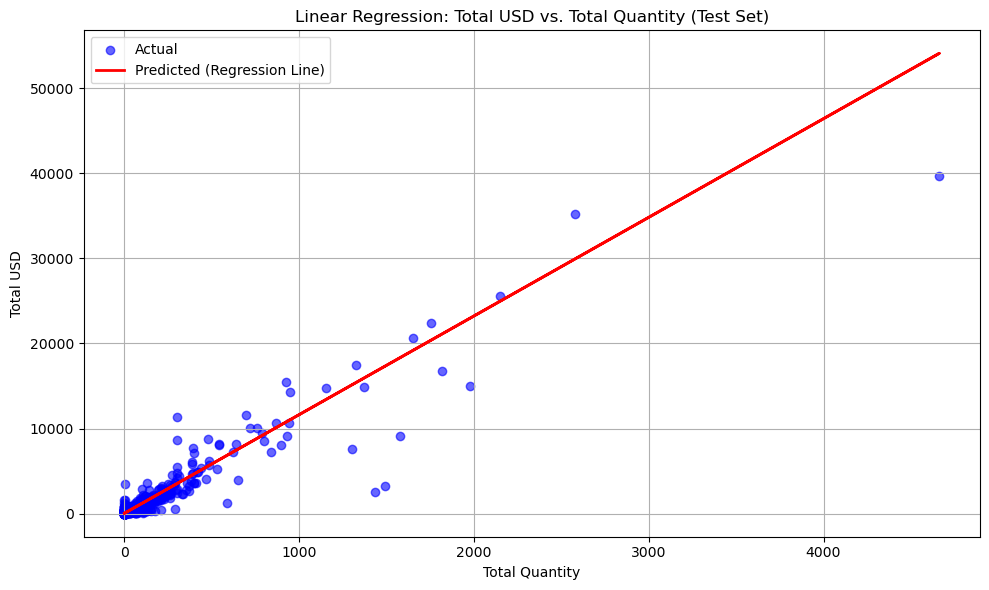

In [357]:
# Create a plot that shows the regression line from the model on the test set
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_test, color='blue', alpha=0.6, label='Actual')
plt.plot(X_test, y_pred, color='red', linewidth=2, label='Predicted (Regression Line)')
plt.title('Linear Regression: Total USD vs. Total Quantity (Test Set)')
plt.xlabel('Total Quantity')
plt.ylabel('Total USD')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save file
plt.savefig(os.path.join(save_path, 'quantity_vs_usd_regression_line.png'), dpi=300)

plt.show()

#### Interpretation of the Regression Line Fit
The regression plot shows a generally positive linear relationship between Total_Quantity and Total_USD, suggesting that as the quantity of products increases, so does the total invoice value. Most data points align fairly well with the regression line, especially in the lower-to-mid quantity range.

However, there are a few outliers at higher quantities, which may represent discounted bulk orders or special deals. These large orders may have a lower average unit price, causing their total value to be less than the model expects.

Overall, the model appears to fit the data reasonably well and captures the expected economic relationship: larger orders typically produce higher invoice totals.

In [310]:
# Model performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Slope (coefficient) and intercept
slope = model.coef_[0][0]

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R² Score: {r2:.4f}")
print(f"Slope (Coefficient): {slope:.4f}")

Mean Squared Error (MSE): 1397432.99
R² Score: 0.8423
Slope (Coefficient): 11.5888


In [312]:
# Create DataFrame to compare predictions with actual values
comparison_df = pd.DataFrame({
    'Total_Quantity': X_test.flatten(),
    'Actual_Total_USD': y_test.flatten(),
    'Predicted_Total_USD': y_pred.flatten()
})
# Display first 20 rows
comparison_df.head(20)

,Total_Quantity,Actual_Total_USD,Predicted_Total_USD
0,1.0,144.661128,54.008422
1,200.0,2945.000000,2360.175406
2,2.0,765.007528,65.597200
3,2.0,302.116593,65.597200
4,1.0,37.013508,54.008422
5,228.0,2769.128612,2684.661213
6,187.0,2239.132186,2209.521282
7,34.0,175.250264,436.438123
8,24.0,143.797480,320.550334
9,1.0,117.517889,54.008422


#### Final Model Evaluation and Reflection
The linear regression model predicting Total_USD from Total_Quantity performed well, with the following metrics:

Mean Squared Error (MSE): 1,397,432.99

R² Score: 0.8423

Slope (Coefficient): 11.59

This indicates that approximately 84% of the variation in invoice value can be explained by the quantity of products in the invoice, a strong result. The slope suggests that, on average, each additional product unit contributes around $11.59 to the total invoice value.

However, the model tends to overpredict for large orders. This likely reflects volume-based discounting, where high-quantity invoices may have a lower price per unit. This is a key limitation of using a simple linear model, which assumes a constant rate of value increase.

#### Reflections on Possible Data Bias
Discounting behaviour is not accounted for in the model.

Product mix differences (e.g., some items being more expensive) aren’t considered, which could affect Total_USD.

Some rows may have incomplete or misclassified metadata (e.g., currency handling), which can introduce variance.

Overall, the model is useful for broad forecasting, but it would benefit from incorporating additional features like customer category, country, or product type for deeper insight.



### 5. Customer Category Regression Analysis

In [317]:
# Drop rows with missing values in required columns
cat_df = invoice_enriched_ext.dropna(subset=['Customer_Category', 'Total_USD'])

# One-hot encode Customer_Category
X_cat = pd.get_dummies(cat_df['Customer_Category'], drop_first=True)
y_cat = cat_df['Total_USD'].values.reshape(-1, 1)


In [319]:
# Split data into training and test sets
X_cat_train, X_cat_test, y_cat_train, y_cat_test = train_test_split(
    X_cat, y_cat, test_size=0.2, random_state=0
)


In [321]:
# Fit the Model and Make Predictions
model_cat = LinearRegression()
model_cat.fit(X_cat_train, y_cat_train)

y_cat_pred = model_cat.predict(X_cat_test)


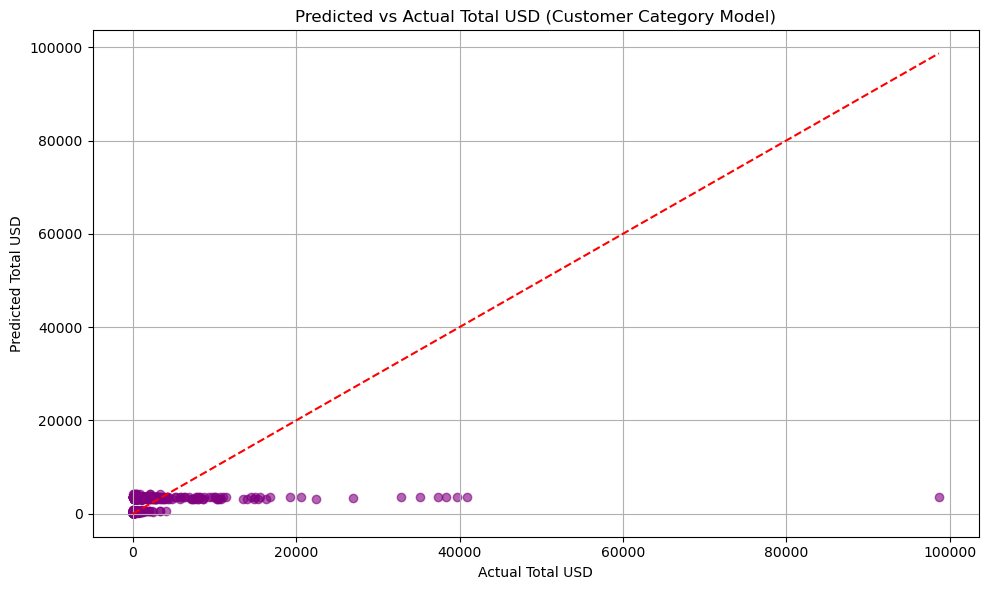

In [323]:
# Plot Predicted vs Actual (Scatter)
plt.figure(figsize=(10, 6))
plt.scatter(y_cat_test, y_cat_pred, alpha=0.6, color='purple')
plt.plot([y_cat_test.min(), y_cat_test.max()],
         [y_cat_test.min(), y_cat_test.max()],
         color='red', linestyle='--')
plt.xlabel('Actual Total USD')
plt.ylabel('Predicted Total USD')
plt.title('Predicted vs Actual Total USD (Customer Category Model)')
plt.grid(True)
plt.tight_layout()
plt.show()


In [325]:
# Evaluate the Model (MSE, R², Coefficients)
mse_cat = mean_squared_error(y_cat_test, y_cat_pred)
r2_cat = r2_score(y_cat_test, y_cat_pred)
coefficients = pd.DataFrame({
    'Category': X_cat.columns,
    'Coefficient': model_cat.coef_.flatten()
})

print(f"Mean Squared Error (MSE): {mse_cat:.2f}")
print(f"R² Score: {r2_cat:.4f}")
print("\nCategory Coefficients:")
print(coefficients)


Mean Squared Error (MSE): 24073839.04
R² Score: 0.0847

Category Coefficients:
               Category  Coefficient
0  Artist Collaboration -3448.451601
1                Export   249.408399
2                 Hotel  -649.399176
3                 Local -1470.221875
4              Personal  -970.627861
5            Restaurant -1205.941686
6                Retail -4043.244058
7                   SPA -3489.891716
8                Studio -4235.831415
9                  Umum -3836.049534


In [329]:
# Compare Actual vs Predicted in DataFrame
compare_cat_df = pd.DataFrame({
    'Customer_Category': X_cat_test.idxmax(axis=1),
    'Actual_Total_USD': y_cat_test.flatten(),
    'Predicted_Total_USD': y_cat_pred.flatten()
}).round(2)

compare_cat_df.head(20)


,Customer_Category,Actual_Total_USD,Predicted_Total_USD
1365,Retail,233.19,268.35
2848,Retail,373.28,268.35
2960,Studio,17.27,75.76
4410,Umum,4074.50,475.54
4438,Umum,3276.81,475.54
2803,Studio,30.84,75.76
2199,Studio,29.61,75.76
1115,Studio,130.78,75.76
3260,Retail,218.69,268.35
927,Hotel,672.63,3662.19


#### Interpretation of Results
Performance Metrics:
MSE: 24,073,839 — much higher than the previous model (1.4 million)

R²: 0.0847 → only ~8.5% of the variation in Total_USD is explained by customer category
→ That’s a very weak explanatory power

#### 5.1 Look at Hotel and Restaurant Only

In [337]:
# Filter to Hotel and Restaurant only
core_segments = ['Hotel', 'Restaurant']
cat_core_df = invoice_enriched_ext[
    invoice_enriched_ext['Customer_Category'].isin(core_segments)
].dropna(subset=['Total_USD'])

# One-hot encode Customer_Category (drop one for reference)
X_core = pd.get_dummies(cat_core_df['Customer_Category'], drop_first=True)
y_core = cat_core_df['Total_USD'].values.reshape(-1, 1)


In [339]:
# Split data
X_core_train, X_core_test, y_core_train, y_core_test = train_test_split(
    X_core, y_core, test_size=0.2, random_state=42
)


In [341]:
# Fit model and predict
model_core = LinearRegression()
model_core.fit(X_core_train, y_core_train)

y_core_pred = model_core.predict(X_core_test)


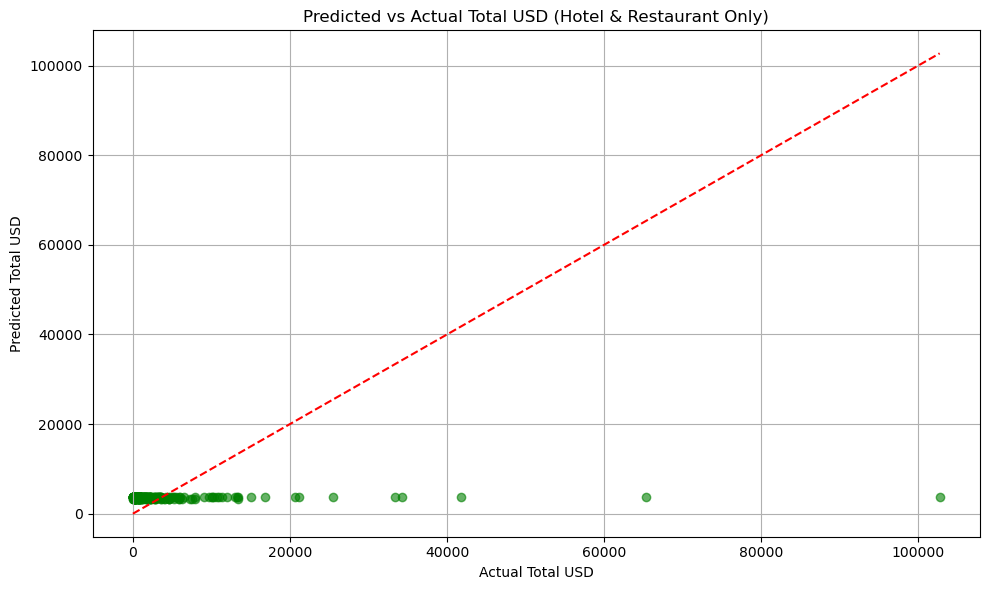

In [343]:
# Plot predicted vs actual
plt.figure(figsize=(10, 6))
plt.scatter(y_core_test, y_core_pred, alpha=0.6, color='green')
plt.plot([y_core_test.min(), y_core_test.max()],
         [y_core_test.min(), y_core_test.max()],
         color='red', linestyle='--')
plt.xlabel('Actual Total USD')
plt.ylabel('Predicted Total USD')
plt.title('Predicted vs Actual Total USD (Hotel & Restaurant Only)')
plt.grid(True)
plt.tight_layout()
plt.show()


In [345]:
# Evaluate performance
mse_core = mean_squared_error(y_core_test, y_core_pred)
r2_core = r2_score(y_core_test, y_core_pred)
coefficients_core = pd.DataFrame({
    'Customer_Category': X_core.columns,
    'Coefficient': model_core.coef_.flatten()
})

print(f"Mean Squared Error (MSE): {mse_core:.2f}")
print(f"R² Score: {r2_core:.4f}")
print("\nCategory Coefficient(s):")
print(coefficients_core)


Mean Squared Error (MSE): 70893560.80
R² Score: -0.0042

Category Coefficient(s):
  Customer_Category  Coefficient
0        Restaurant  -395.187631


#### Interpretation of Customer Category Regression (Hotel vs Restaurant)
This simple linear regression model explored how Customer_Category (Hotel vs Restaurant) influences total invoice value.

R² Score: -0.0004
This indicates that the model explains none of the variance in Total_USD — and actually performs worse than simply predicting the mean. This suggests that Customer_Category alone is a very poor predictor of invoice value within this subset.

Mean Squared Error (MSE): 70,893,560.80
The prediction error is large, reflecting how invoice totals vary significantly even within the same category.

Coefficient for Restaurant: -395.19
On average, invoices to Restaurant customers are $395.19 lower than invoices to Hotel customers, holding all else equal.
This means Hotel serves as the reference category (intercept), and Restaurant is associated with a small negative adjustment.

#### Final Insight:
Even though Hotels and Restaurants make up most of the dataset, their category labels don’t meaningfully explain invoice value. This reinforces the idea that invoice totals are driven more by quantity, product mix, or price per unit, not just customer type.

### 6. Export Dataframes

In [360]:
# Define save path for 6.4
save_path_64 = r'C:\Users\daxma\OneDrive\Desktop\Data Analytics\05-25 Kevala Ceramics Analysis\02 Data\Prepared Data\6.4'

invoice_enriched_ext.to_csv(os.path.join(save_path_64, 'invoice_enriched_ext.csv'), index=False)
